<a href="https://colab.research.google.com/github/JonathanMartignon/LicenciaturaCienciaDeDatos/blob/main/Mineria_de_Datos/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Conteo por audio (Basado en redes convolucionales y espectogramas)

## Integrantes:
- Martiñón Luna Jonathan José

## Licenciatura en Ciencia de Datos
## Minería de Datos Avanzada
## Universidad Nacional Autónoma de México 


---
# 1.) Librerías
---

In [1]:
#Google Drive
from google.colab import drive

#Tiempo de ejecucion
from time import time

# Graficos
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

# DataFrames
import pandas as pd

# Arreglos multidimensionales
import numpy as np

# Reproducción de audio
from IPython.display import Audio

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
   # Audio
try:  
  import tensorflow_io as tfio
except:
  !pip install tensorflow-io
  import tensorflow_io as tfio

     |████████████████████████████████| 24.1MB 125kB/s 
     |████████████████████████████████| 2.5MB 48.7MB/s 


---
# 2.) Funciones
---

In [2]:
def presenta_onda_spect_y_audio(meta, conjunto="Entrenamiento",seed = 2209,
                                nfft=158, window=512, stride=400//2,
                                figsize = (12,6)):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:   Función encargada de mostrar durante el análisis
                  un audio (dependiendo del conjunto seleccionado),
                  su forma y su espectograma.

  @Parámetros:

  meta            Conjunto de metadatos sobre el audio elegido  PANDAS.DATAFRAME

  conjunto        Conjunto del que se extraerá el audio         STR

  seed            Semilla para replicabilidad                   INT

  nfft            tamaño de la muestra                          INT

  window          tamaño de la ventana                          INT

  stride          Tamaño del salto entre ventanas               INT

  figsize         Tamaño del liezo (Figura) de matplotlib       TUPLE
  '''
  # Ajustamos la semilla de nuestro numpy
  np.random.seed(seed)

  if conjunto == "Entrenamiento":
    # Generamos un número aleatorio entre 0 y 100,000
    numero = np.random.randint(low=0,high=100000,dtype=int)
    # Generamos el nombre del audio
    name_audio = "Audio_Train"+str(numero)+".wav"

  elif conjunto == "Validacion":
    # Generamos un número aleatorio entre 0 y 10,000
    numero = np.random.randint(low=0,high=10000,dtype=int)
    # Generamos el nombre del audio
    name_audio = "Audio_Validation"+str(numero)+".wav" 

  else:
    # Generamos un número aleatorio entre 0 y 10,000
    numero = np.random.randint(low=0,high=10000,dtype=int)
    # Generamos el nombre del audio
    name_audio = "Audio_Test"+str(numero)+".wav"

  # Obtenemos la cantidad de hablantes
  hablantes = meta.loc[numero]['Speakers']

  dir_audio = "./Data/"+conjunto+"/"+name_audio 

  # Leemos el audio
  audio = tfio.audio.AudioIOTensor(dir_audio)
  # Convertimos a tensor
  audio_tensor = tf.squeeze(audio[:], axis=[-1])
  

  # Generamos nuestra forma de audio
  waveform = tf.cast(audio_tensor, tf.float32).numpy()

  # Generamos nuestro spectograma
  spectrogram_crud = tfio.audio.spectrogram(
      audio_tensor, nfft=nfft, window=window, stride=stride)
  # Convertimos a Decibeles
  spectrogram = tfio.audio.dbscale(spectrogram_crud, top_db=80)

  # Finalmente graficamos ambos casos
  plt.figure(figsize=figsize)

  # Para la forma de audio
  plt.subplot(1,2,1)
  plt.title(f"Forma de audio para el conjunto de: {conjunto}\nCon {hablantes} hablantes.")
  plt.plot(waveform,color = "orange")
  plt.yticks([])
  plt.xlabel("Tiempo")

  # Para el espectrograma
  plt.subplot(1,2,2)
  plt.title(f"Espectrograma del audio para el conjunto de: {conjunto}\nCon {hablantes} hablantes.\nShape: {spectrogram.shape}")
  plt.imshow(spectrogram)
  cbar = plt.colorbar(shrink=0.75)
  cbar.set_label('DB')
  plt.yticks([])
  plt.xlabel("Tiempo")

  plt.tight_layout()
  plt.show()

  # Reproductor del audio
  Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

In [37]:
def genera_conjunto(conjunto = "Entrenamiento",num = 100000,
                    nfft=158, window=512, stride=400//2):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:   Función encargada de mostrar durante el análisis
                  un audio (dependiendo del conjunto seleccionado),
                  su forma y su espectograma.

  @Parámetros:

  conjunto        Conjunto del que se extraerá el audio   STR
  
  num             Cantidad de elmentos del conjunto       INT 

  nfft            tamaño de la muestra                    INT

  window          tamaño de la ventana                    INT

  stride          Tamaño del salto entre ventanas         INT

  @Devuelve:

  data            Arreglo de (n,80,80,1) para cada        NUMPY.ARRAY
                  conjunto
  '''
  
  if conjunto == "Entrenamiento":
    # Generamos el nombre del audio
    name_audio = "Audio_Train"

  elif conjunto == "Validacion":
    # Generamos el nombre del audio
    name_audio = "Audio_Validation"

  else:
    # Generamos el nombre del audio
    name_audio = "Audio_Test"

  for i in range(0,num):


    # Leemos el audio
    audio = tfio.audio.AudioIOTensor("./Data/"+conjunto+"/"+name_audio+str(i)+".wav")

    # Convertimos a tensor
    audio_tensor = tf.squeeze(audio[:], axis=[-1])

    # Generamos nuestro spectograma
    spectrogram_crud = tfio.audio.spectrogram(
        audio_tensor, nfft=nfft, window=window, stride=stride)
    
    # Convertimos a Decibeles
    spectrogram = tfio.audio.dbscale(spectrogram_crud, top_db=80)

    # Ajustamos la dimensión a 80,80,1
    new_spectrogram = spectrogram.numpy().reshape(80,80,1)

    # Agregamos al conjunto
    if i == 0:
      # En caso de ser el primero, será nuestro arreglo base
      data = np.array([new_spectrogram])
    else:
      # En otro caso, concatenaremos para finalizar con algo de la forma
      # (n,80,80,1) Similar a la forma de trabajo de los datasets de tf.
      data = np.append(data,[new_spectrogram],axis=0)
    
    # Nuestra bandera para conocer el avance
    if i%1000 == 0:
      print(f"Estamos en el audio: {name_audio}{i}.wav")

  return data

---
# 3.) Pre-procesamiento
---

## 3.1 Carga de datos

Montamos drive, para realizar la extracción de los datos a utilizar.

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Para los casos de *recarga* del notebook, eliminamos la carpeta datos, y evitamos que se dupliquen los datos

In [5]:
# !rm -r "Data"

Movemos los archivos a una carpeta específica (./Data), para no tener que buscarlos o ingresar la dirección completa. 

Comenzamos por descargar los metadatos

In [6]:
!mkdir "./Data"
!cp "drive/MyDrive/Proyecto_MDA/Validacion.csv" "Data"
!cp "drive/MyDrive/Proyecto_MDA/Entrenamiento.csv" "Data"
!cp "drive/MyDrive/Proyecto_MDA/Prueba.csv" "Data"

Posteriormente, cargamos cada uno de los audios

In [7]:
!unzip -q "drive/My Drive/Proyecto_MDA/Audios_Prueba.zip" -d "./Data"
!unzip -q "drive/My Drive/Proyecto_MDA/Audios_Validacion.zip" -d "./Data"
!unzip -q "drive/My Drive/Proyecto_MDA/Audio_Entrenamiento.zip" -d "./Data"

Una vez que ya contamos con los archivos necesarios, procedemos a desmontar nuestro drive.

In [8]:
drive.flush_and_unmount()

Damos una pre-visualización de los datos que contamos

In [9]:
! ls -R {'Data'} | head -8

Data:
Entrenamiento
Entrenamiento.csv
Prueba
Prueba.csv
Validacion
Validacion.csv



## 3.2) Lectura de Datos

Leemos los *csv* que contienen información acerca de nuestros audios.

In [10]:
entrenamiento_df = pd.read_csv("./Data/Entrenamiento.csv")
validacion_df = pd.read_csv("./Data/Validacion.csv")
prueba_df = pd.read_csv("./Data/Prueba.csv")

Generamos una columna con los datos a predecir (el número de hablantes en el audio)

In [11]:
entrenamiento_df['Speakers_Class'] = entrenamiento_df['Speakers'] - 1
validacion_df['Speakers_Class'] = validacion_df['Speakers'] - 1
prueba_df['Speakers_Class'] = prueba_df['Speakers'] - 1

## 3.3) Análisis de datos

### 3.3.1) Balance de datos

In [12]:
colors = ["deepskyblue","steelblue","paleturquoise"]

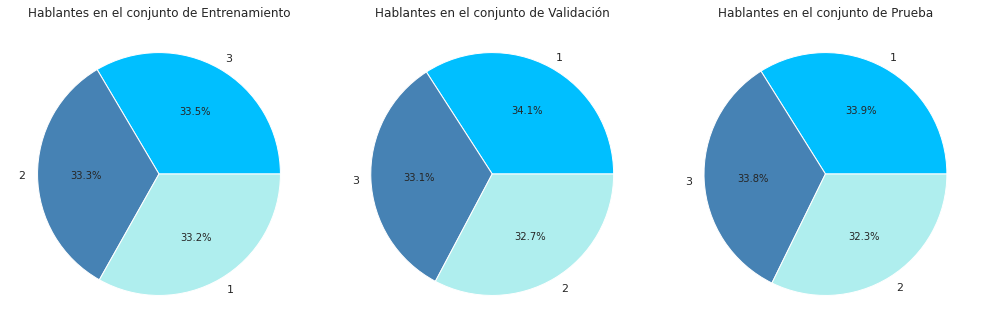

In [13]:
plt.figure(figsize=(14,14))

plt.subplot(1,3,1)
plt.pie(entrenamiento_df["Speakers"].value_counts(), 
        labels=entrenamiento_df["Speakers"].value_counts().index,
        autopct="%1.1f%%", colors=colors)
plt.title("Hablantes en el conjunto de Entrenamiento")

plt.subplot(1,3,2)
plt.pie(validacion_df["Speakers"].value_counts(), 
        labels=validacion_df["Speakers"].value_counts().index,
        autopct="%1.1f%%", colors=colors)
plt.title("Hablantes en el conjunto de Validación")

plt.subplot(1,3,3)
plt.pie(prueba_df["Speakers"].value_counts(), 
        labels=prueba_df["Speakers"].value_counts().index,
        autopct="%1.1f%%", colors=colors)
plt.title("Hablantes en el conjunto de Prueba")

plt.tight_layout()
plt.show()

De las figuras anteriores, podremos observar que nuestros datos se encuentran completamente balanceados (En cuanto al número de hablantes, que es lo que nos interesa).

### 3.3.2) Metadatos

In [14]:
entrenamiento_df.head()

,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[-0.00354004 -0.00354004 -0.00372314 ... 0.00...,1,F,1,0,0
1,[-0.05560303 -0.03948975 -0.01425171 ... 0.06...,1,M,0,1,0
2,[0.08041382 0.10652161 0.13059998 ... 0.017501...,2,FF,2,0,1
3,[0.00216675 0.00177002 0.00131226 ... 0.022705...,1,M,0,1,0
4,[ 0.0064799 0.00262451 0.00343831 ... -0.00...,3,FFF,3,0,2


In [15]:
validacion_df.head()

,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.0045166 0.00930786 -0.00366211 ... 0.02...,1,M,0,1,0
1,[ 0.02026367 0.02442932 0.02787781 ... -0.00...,2,MM,0,2,1
2,[-0.03646851 -0.03983561 -0.04340617 ... -0.03...,3,MMF,1,2,2
3,[ 0.02868652 0.0123291 0.00295003 ... -0.02...,3,MMM,0,3,2
4,[0.01849365 0.02142334 0.01538086 ... 0.020345...,3,MMM,0,3,2


In [16]:
prueba_df.head()

,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.00117493 0.00216675 0.0037384 ... -0.01...,2,MF,1,1,1
1,[-3.0517578e-05 1.8310547e-04 2.5939941e-04 ...,2,MF,1,1,1
2,[-0.03262329 -0.03387451 -0.03366089 ... 0.00...,1,M,0,1,0
3,[-0.03912354 -0.02819824 -0.02289836 ... -0.10...,3,MMM,0,3,2
4,[ 0.00628662 0.01490784 0.01811218 ... -0.01...,2,MF,1,1,1


Tal cual podemos observar, existen 6 columnas para cada conjunto:
- **Waveform:** Una breve ilustración (string) de lo que es el audio
- **Speakers:** Cantidad de hablantes en el audio
- **Speakers_Sex:** Distribución de Hablantes (M: Masculino, F: Femenino)
- **F:** Cantidad de hablantes femeninos
- **M:** Cantidad de hablantes masculinos
- **Speakers_Class:** Clase a la que pertenece el audio

### 3.3.2 Audios

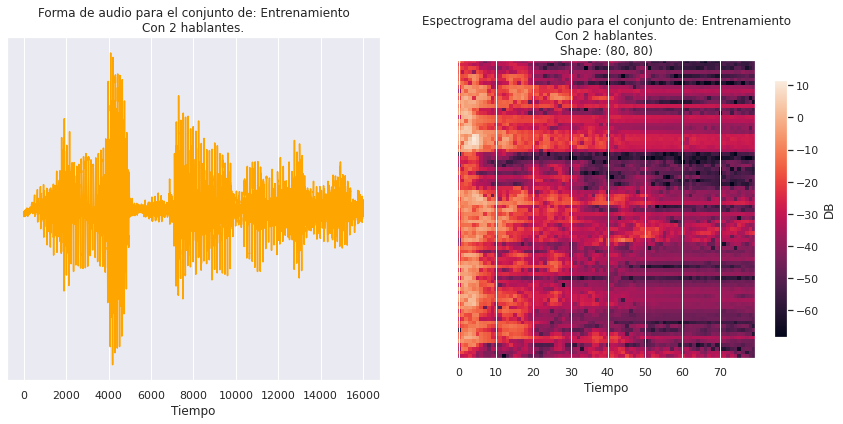

In [17]:
presenta_onda_spect_y_audio(entrenamiento_df, conjunto="Entrenamiento")

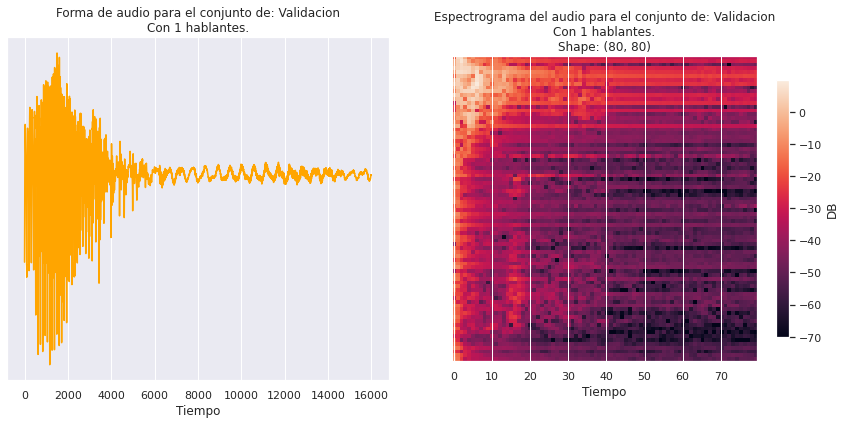

In [18]:
presenta_onda_spect_y_audio(validacion_df, conjunto="Validacion")

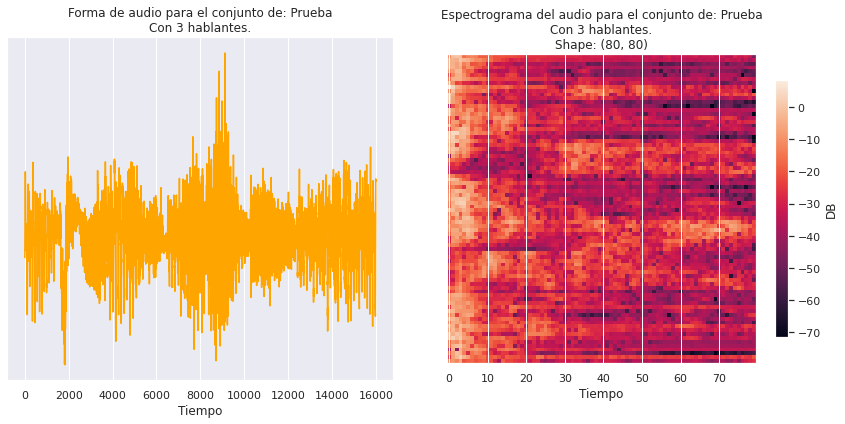

In [19]:
presenta_onda_spect_y_audio(prueba_df, conjunto="Prueba")

# 4.) Generación de Conjuntos 

## 4.1) Valores en X

In [21]:
start = time()
val_data = genera_conjunto(conjunto = "Validacion",num = 10000)
print(f"Tardó:{round((time()-start)/60,2)} minutos")

Tardó:-7.9669613202412926 minutos


In [22]:
val_data.shape

(10000, 80, 80, 1)

In [23]:
start = time()
test_data = genera_conjunto(conjunto = "Prueba",num = 10000)
print(f"Tardó:{round((time()-start)/60,2)} minutos")

Tardó:-7.65026445388794 minutos


In [31]:
test_data.shape

(10000, 80, 80, 1)

In [38]:
start = time()
train_data = genera_conjunto(num = 30000)
print(f"Tardó:{round((time()-start)/60,2)} minutos")

Estamos en el audio: Audio_Train0.wav
Estamos en el audio: Audio_Train1000.wav
Estamos en el audio: Audio_Train2000.wav
Estamos en el audio: Audio_Train3000.wav
Estamos en el audio: Audio_Train4000.wav
Estamos en el audio: Audio_Train5000.wav
Estamos en el audio: Audio_Train6000.wav
Estamos en el audio: Audio_Train7000.wav
Estamos en el audio: Audio_Train8000.wav
Estamos en el audio: Audio_Train9000.wav
Estamos en el audio: Audio_Train10000.wav
Estamos en el audio: Audio_Train11000.wav
Estamos en el audio: Audio_Train12000.wav
Estamos en el audio: Audio_Train13000.wav
Estamos en el audio: Audio_Train14000.wav
Estamos en el audio: Audio_Train15000.wav
Estamos en el audio: Audio_Train16000.wav
Estamos en el audio: Audio_Train17000.wav
Estamos en el audio: Audio_Train18000.wav
Estamos en el audio: Audio_Train19000.wav
Estamos en el audio: Audio_Train20000.wav
Estamos en el audio: Audio_Train21000.wav
Estamos en el audio: Audio_Train22000.wav
Estamos en el audio: Audio_Train23000.wav
Estam

In [39]:
train_data.shape

(30000, 80, 80, 1)

## 4.2) Valores en Y

In [41]:
train_labels=entrenamiento_df["Speakers_Class"][:30000].values.reshape(-1,1)
test_labels=prueba_df["Speakers_Class"][:].values.reshape(-1,1)
val_labels=validacion_df["Speakers_Class"][:].values.reshape(-1,1)

In [42]:
train_labels.shape, test_labels.shape, val_labels.shape

((30000, 1), (10000, 1), (10000, 1))

# 5.) Modelado

Trabajaremos con 2 modelos distintos

## 5.1) Modelo1

Nuestro primer modelo es una extensión del ejemplo desarrollado por Tensorflow en su página para [redes convolucionales](https://www.tensorflow.org/tutorials/images/cnn)

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(80, (3, 3), activation='relu', input_shape=(80, 80,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(160, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(160, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(320, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(320, activation='relu'))
model.add(layers.Dense(3))

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 78, 78, 80)        800       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 39, 80)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 80)        57680     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 80)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 160)       115360    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 160)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 6, 160)        

## 5.2) Modelo 2
El segundo modelo

In [56]:
model2 = models.Sequential()
model2.add(layers.Conv2D(80, (3, 3), activation='relu', input_shape=(80, 80,1)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.Conv2D(80, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.Conv2D(160, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.Conv2D(320, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D((2, 2)))
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Flatten())
model.add(layers.Dense(320, activation='relu'))
model2.add(layers.Dense(3))

In [57]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 78, 78, 80)        800       
_________________________________________________________________
batch_normalization_8 (Batch (None, 78, 78, 80)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 39, 39, 80)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 37, 37, 80)        57680     
_________________________________________________________________
batch_normalization_9 (Batch (None, 37, 37, 80)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 18, 18, 80)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 160)      

# 6.) Compilando y entrenando el modelo

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_data, train_labels, epochs=20, 
                    validation_data=(val_data, val_labels))

Epoch 1/20
938/938 [==============================] - 57s 26ms/step - loss: 0.9420 - accuracy: 0.5657 - val_loss: 0.7738 - val_accuracy: 0.6734
Epoch 2/20
938/938 [==============================] - 24s 26ms/step - loss: 0.6860 - accuracy: 0.6897 - val_loss: 0.6870 - val_accuracy: 0.7066
Epoch 3/20
938/938 [==============================] - 24s 25ms/step - loss: 0.6244 - accuracy: 0.7211 - val_loss: 0.6165 - val_accuracy: 0.7257
Epoch 4/20
938/938 [==============================] - 23s 24ms/step - loss: 0.5784 - accuracy: 0.7425 - val_loss: 0.6229 - val_accuracy: 0.7292
Epoch 5/20
938/938 [==============================] - 22s 24ms/step - loss: 0.5433 - accuracy: 0.7623 - val_loss: 0.5867 - val_accuracy: 0.7483
Epoch 6/20
938/938 [==============================] - 22s 23ms/step - loss: 0.5107 - accuracy: 0.7764 - val_loss: 0.6333 - val_accuracy: 0.7291
Epoch 7/20
938/938 [==============================] - 21s 22ms/step - loss: 0.4717 - accuracy: 0.7977 - val_loss: 0.7105 - val_accuracy:

In [61]:
with tf.device('/device:GPU:0'):
  history2 = model2.fit(train_data, train_labels, epochs=20, 
                    validation_data=(val_data, val_labels))

Epoch 1/20
938/938 [==============================] - 22s 23ms/step - loss: 0.6657 - accuracy: 0.6963 - val_loss: 0.9948 - val_accuracy: 0.5233
Epoch 2/20
938/938 [==============================] - 21s 23ms/step - loss: 0.5927 - accuracy: 0.7323 - val_loss: 2.4808 - val_accuracy: 0.3454
Epoch 3/20
938/938 [==============================] - 21s 23ms/step - loss: 0.5535 - accuracy: 0.7544 - val_loss: 0.7049 - val_accuracy: 0.6852
Epoch 4/20
938/938 [==============================] - 21s 23ms/step - loss: 0.5202 - accuracy: 0.7681 - val_loss: 1.0718 - val_accuracy: 0.5597
Epoch 5/20
938/938 [==============================] - 21s 23ms/step - loss: 0.4866 - accuracy: 0.7846 - val_loss: 1.0342 - val_accuracy: 0.5715
Epoch 6/20
938/938 [==============================] - 21s 23ms/step - loss: 0.4569 - accuracy: 0.8001 - val_loss: 0.7120 - val_accuracy: 0.6933
Epoch 7/20
938/938 [==============================] - 21s 23ms/step - loss: 0.4220 - accuracy: 0.8163 - val_loss: 0.6167 - val_accuracy:

# 7.) Evaluando los modelos

In [62]:
with tf.device('/device:GPU:0'):
  resultado_1 = model.evaluate(test_data, test_labels)

313/313 [==============================] - 2s 8ms/step - loss: 1.4097 - accuracy: 0.7151


In [63]:
with tf.device('/device:GPU:0'):
  resultado_2 = model2.evaluate(test_data, test_labels)

313/313 [==============================] - 3s 8ms/step - loss: 1.6426 - accuracy: 0.6996


# 7.) Interpretándo resultados

In [ ]:
hist = pd.DataFrame(history.history)
hist2 = pd.DataFrame(history2.history)

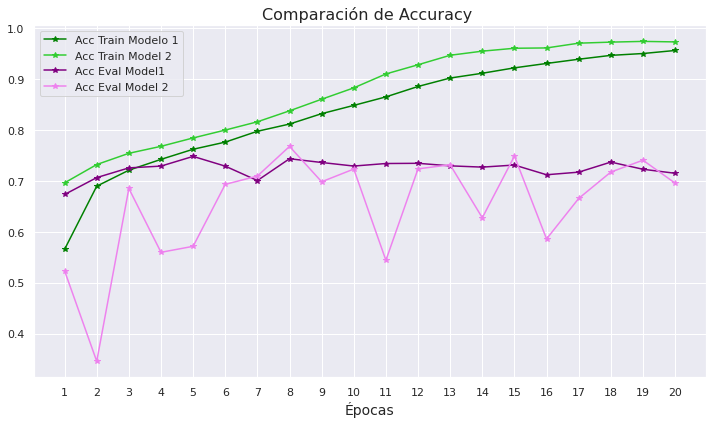

In [81]:

plt.figure(figsize=(10,6))

plt.plot(hist["accuracy"],label="Acc Train Modelo 1",marker="*",color="green")
plt.plot(hist2["accuracy"],label="Acc Train Model 2",marker="*",color="limegreen")
plt.plot(hist["val_accuracy"],label="Acc Eval Model1",marker="*",color="purple")
plt.plot(hist2["val_accuracy"],label="Acc Eval Model 2",marker="*",color="violet")

plt.title('Comparación de Accuracy ',fontsize = 16)
plt.legend()
plt.xticks(np.arange(0,len(history.history["accuracy"])),
           np.arange(1,len(history.history["accuracy"])+1))
plt.xlabel("Épocas",fontsize = 14)
plt.tight_layout()
plt.show()

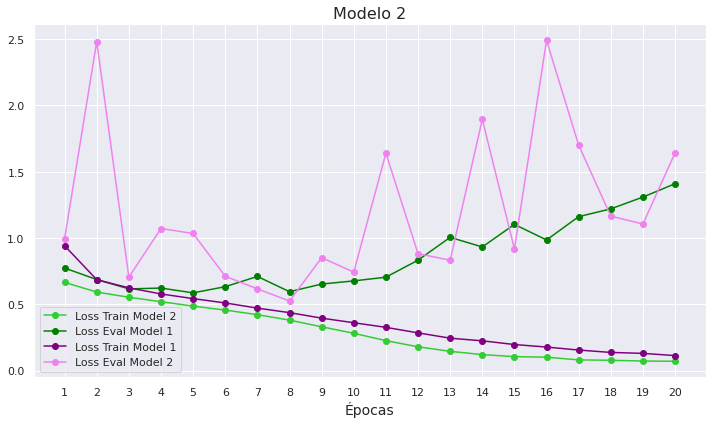

In [82]:

plt.figure(figsize=(10,6))


plt.plot(hist2["loss"],label="Loss Train Model 2",marker="o",color="limegreen")
plt.plot(hist["val_loss"],label="Loss Eval Model 1",marker="o",color="green")
plt.plot(hist["loss"],label="Loss Train Model 1",marker="o",color="purple")
plt.plot(hist2["val_loss"],label="Loss Eval Model 2",marker="o",color="violet")
plt.title('Modelo 2',fontsize = 16)
plt.legend()
plt.xticks(np.arange(0,len(history2.history["accuracy"])),
           np.arange(1,len(history2.history["accuracy"])+1))
plt.xlabel("Épocas",fontsize = 14)
plt.tight_layout()
plt.show()